## Machine Learning
### RIHAD VARIAWA

In this report I present findings from an exploration of the NYC benchmarking dataset which measures 60 variables related to energy usage for over 11,000 buildings. Of primary interest is the **Energy Star Score,** which is often used as an aggregate measure of the overall energy efficiency of a building. The **Energy Star Score** is a percentile measure of a building's energy performance / efficiency computed from **Self-Reported-Energy-Usage.** 

### Objectives

* Identify predictors within the dataset for the Energy Star Score
* Build Regression/Classification models that can predict the Energy Star Score of a building given the building's energy data
* Interpret the results of the model and use the trained model to infer the Energy Star Scores of new buildings

Documentation of the column names can be found in [this document](http://www.nyc.gov/html/gbee/downloads/pdf/2016_nyc_benchmarking_data_disclosure_definitions.pdf). Preliminary data cleaning and exploration was completed in another Jupyer Notebook.

In [0]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.pylabtools import figsize

import seaborn as sns
sns.set_context(font_scale=2)

# Imputing missing values
from sklearn.preprocessing import Imputer

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# Evaluating Models
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

# Helpers
import itertools

In [2]:
from google.colab import files
uploaded = files.upload()

Saving cleaned_data.csv to cleaned_data.csv


In [3]:
# Read in cleaned data and display shape
data = pd.read_csv('cleaned_data.csv')
print(data.shape)

(11746, 60)


There are over 11,000 buildings in the dataset with 60 energy-related features. Many of the columns contain a significant portion of missing values which were initially encoded as 'Not Available'. In a previous notebook, I filled in the missing values with nan and converted the appropriate columns to numerical values.

## Data Exploration

As we are concerned mainly with the Energy Star Scores, the first chart shows the distribution of this measure across all the buildings in the dataset that have a score (9642).

### Distribution of Energy Star Scores

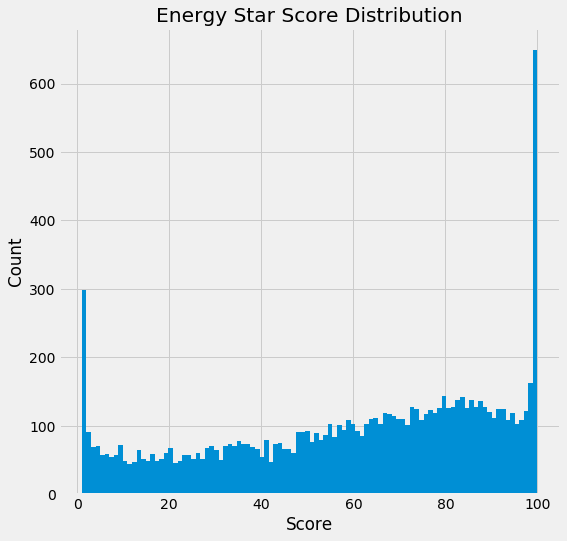

In [4]:
plt.style.use('fivethirtyeight')
figsize(8, 8)

# Histogram of Energy Star Scores with 100 bins
plt.hist(data['ENERGY STAR Score'].dropna(), bins = 100);
plt.title('Energy Star Score Distribution'); 
plt.xlabel('Score'); plt.ylabel('Count');

### Potential Issue with Energy Star Scores

The Energy Star Score is a measure based on the __self-reported__ energy usage of a building (see [this documentation](https://www.tandfonline.com/doi/pdf/10.1080/09613218.2014.887612) for a thorough discussion) which is supposed to represent the percentile energy performance rank of a building. Given the above distribution, either this dataset has a high portion of extraordinarily efficient buildings, or the measure is not objective. Roughly 7% of the buildings have a score of exactly 100, but we would expect the distribution to be uniform across scores because this is a percentile measure. 

In contrast to the Energy Star Score, the Energy Use Intensity (EUI) is based on actual energy use as determined by the utility. It is straightforward to calculate: take the total annual energy usage (in kBtu) and divide by the square footage of the building. The EUI is meant for normalized energy use comparisons between buildings of the same building type. This measure is likely more objective because it uses actual measure consumption. In the graph below we can see that the distribution of EUI is normal, which is what we would expect from a random variable. 

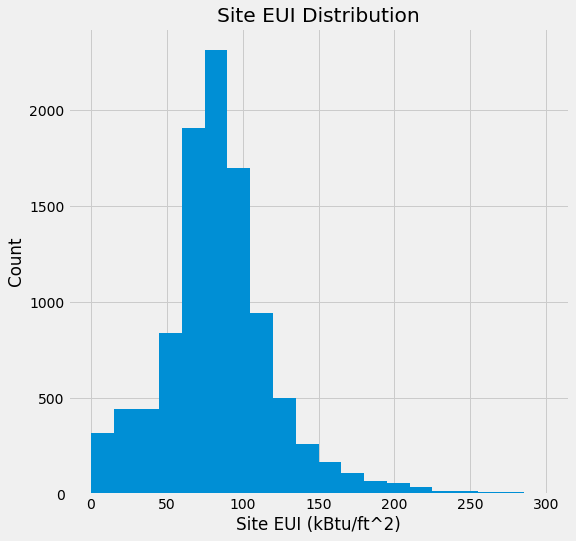

In [5]:
figsize(8, 8)

# Histograms of Site EUI across all buildings in dataset
plt.hist(data['Weather Normalized Site EUI (kBtu/ft²)'].dropna(), 
         bins = 20, range = (0, 300));
plt.title('Site EUI Distribution'); plt.xlabel('Site EUI (kBtu/ft^2)'); 
plt.ylabel('Count');

Even though there are issues with the Energy Star Scores, this analysis will focus on that measure. However, further investigative work should be carried out on these scores to determine why the distribution is unusual. Given the suspect distribution of this value, it would be worthwhile to find a better overall measure of a building's energy performance. We can still try to predict the Energy Star Scores, but just because we can predict a value does not mean it is useful!

### Energy Star Score by Building Type

In order to determine if certain building types tend to score better or worse on the Energy Star Score, we can plot the distribution of energy star scores by buiding type. Following is a density plot showing the distribution of scores for building types with more than 80 measurements in the data. 

The kernel density plot x-limits do extend beyond the range of actual scores because of the [kernel density estimation](https://web.as.uky.edu/statistics/users/pbreheny/621/F10/notes/10-28.pdf) method used to make the probability density distribution. The actual values in a density plot can be difficult to interpret, and it is more instructive to focus on the distribution/shape of the figure.

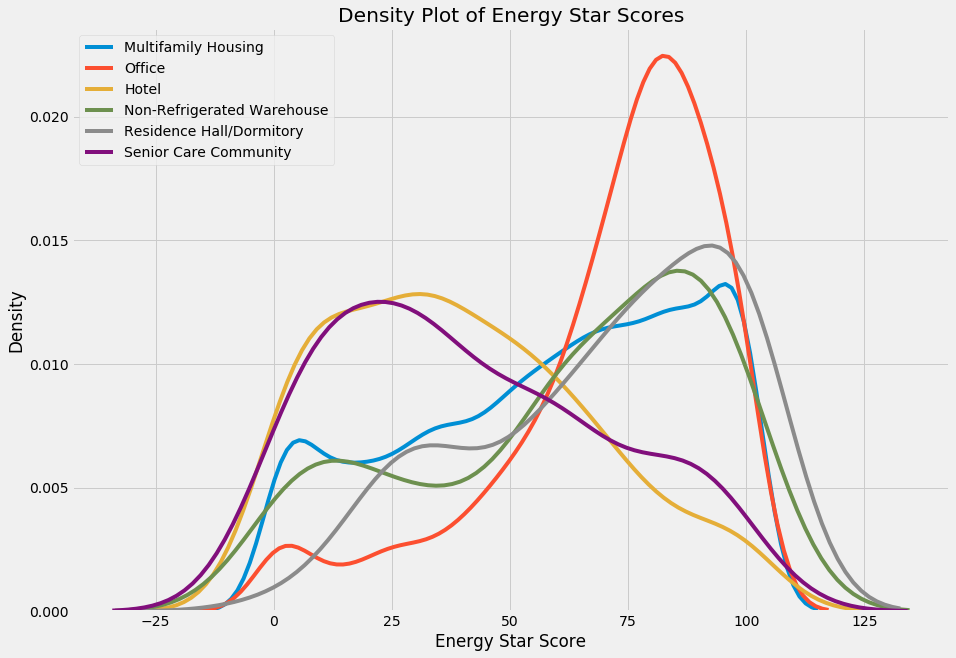

In [6]:
# Create a list of buildings with more than 80 measurements
types = data.dropna(subset=['ENERGY STAR Score'])
types = types['Primary Property Type - Self Selected'].value_counts()
types = list(types[types.values > 80].index)

figsize(14, 10)

# Plot each building
for b_type in types:
    # Select the building type
    subset = data[data['Primary Property Type - Self Selected'] == b_type]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['ENERGY STAR Score'].dropna(),
               label = b_type);
    
plt.xlabel('Energy Star Score'); plt.ylabel('Density'); 
plt.title('Density Plot of Energy Star Scores');

This gives us our first conclusion: office buildings tend to have much higher Energy Star Scores than hotels and senior care communities. Residence halls and non-refrigerated warehouses also have higher scores while multifamily housing has a bi-modal distribution of scores similar to the overall distribution. It would be useful to see if this holds across a larger sample size, and to get more data to figure out why some building types tend to do better. 

In the exploration notebook, I've identified that there was a negative correlation between the Site EUI and the Energy Star Score. We can plot the Site EUI by building type to see if there is also a difference in Site EUI between building types.

### Site EUI by Building Type

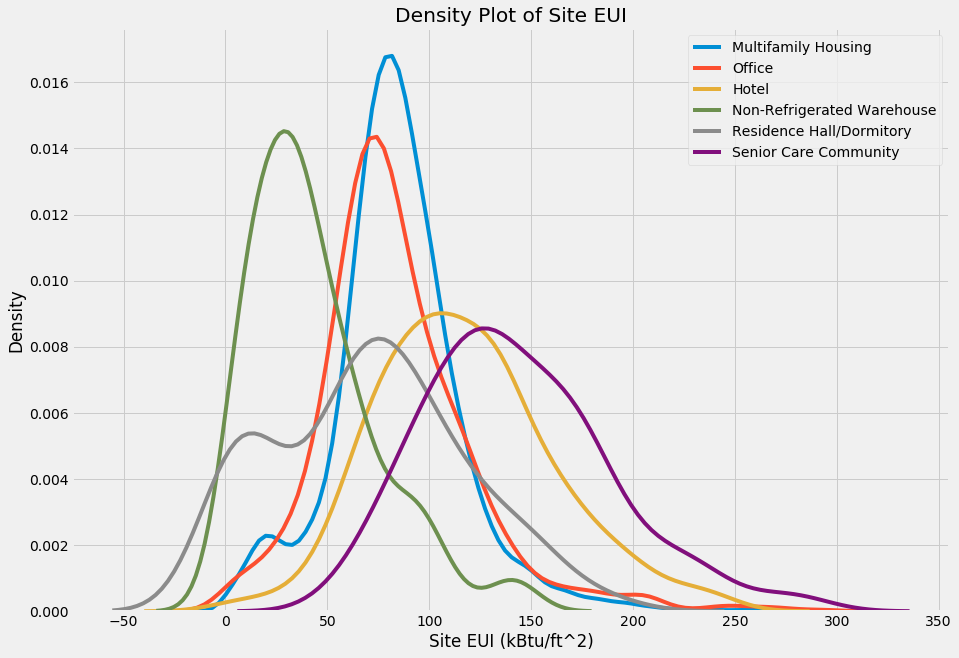

In [7]:
figsize(14, 10)

# Plot the site EUI density plot for each building type
for b_type in types:
    # Remove outliers before plotting
    subset = data[(data['Weather Normalized Site EUI (kBtu/ft²)'] < 300) & 
                     (data['Primary Property Type - Self Selected'] == b_type)]
    
    # Plot the site EUI on a density plot
    sns.kdeplot(subset['Weather Normalized Site EUI (kBtu/ft²)'].dropna(), 
                label = b_type);
    
plt.xlabel('Site EUI (kBtu/ft^2)'); plt.ylabel('Density'); 
plt.title('Density Plot of Site EUI');

This plot provides us with another conclusion: there appears to be a negative correlation between the Site EUI and the Energy Star Score based on comparing the two distributions between building types. Building types with lower Site EUI's tend to have higher Energy Star Scores. The higher the energy use intensity (which is energy use / area), the "worse" the building's energy efficiency performance. We can visualize the relationship between the Energy Star Score and the Site EUI in a scatterplot.

### Energy Star Score versus Site EUI

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


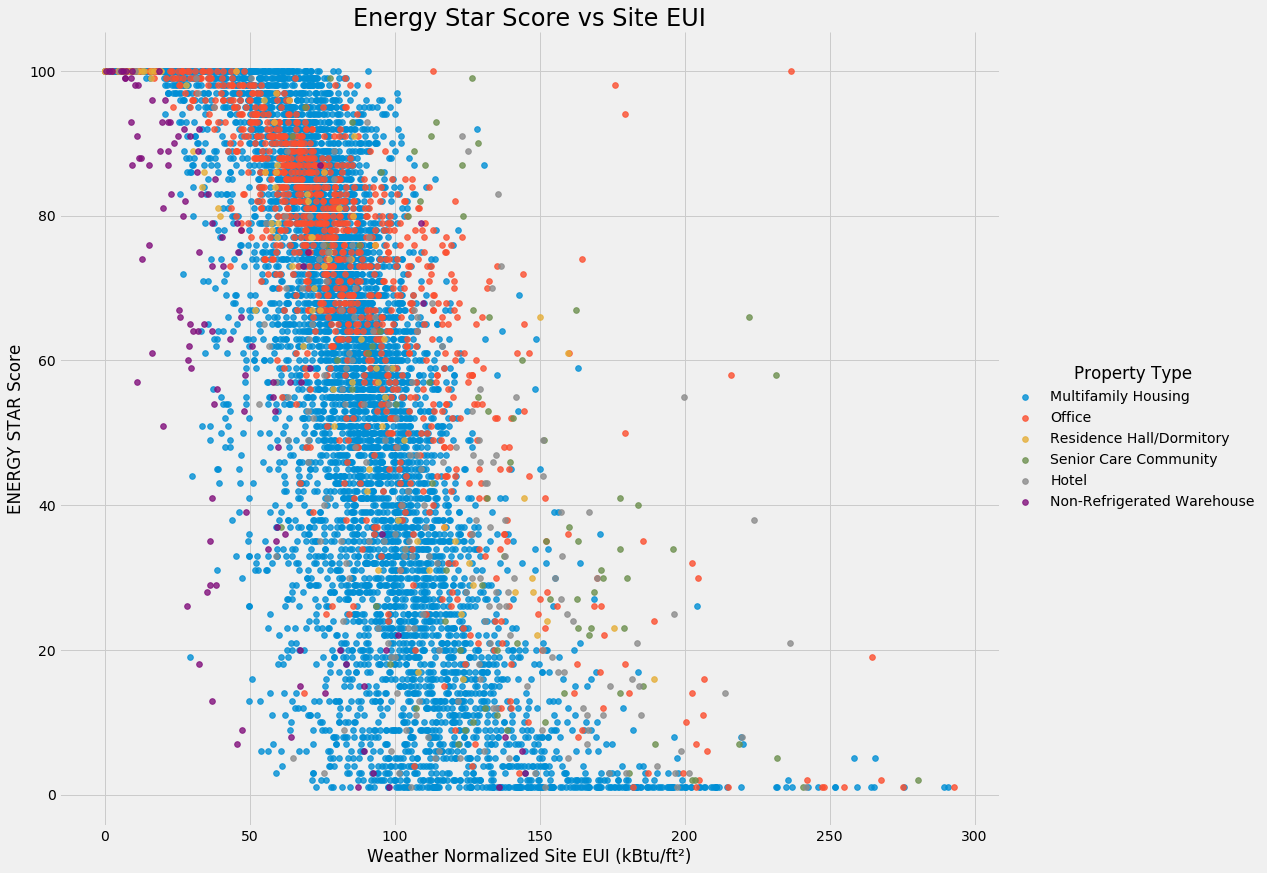

In [8]:
figsize(14, 10)

# Subset to the buildings with most measurements and remove outliers
subset = data[(data['Weather Normalized Site EUI (kBtu/ft²)'] < 300) & 
             (data['Primary Property Type - Self Selected'].isin(types))]

# Drop the buildings without a value
subset = subset.dropna(subset=['ENERGY STAR Score', 
                               'Weather Normalized Site EUI (kBtu/ft²)'])

subset = subset.rename(columns={'Primary Property Type - Self Selected': 'Property Type'})


# Linear Plot of Energy Star Score vs EUI
sns.lmplot('Weather Normalized Site EUI (kBtu/ft²)', 'ENERGY STAR Score', 
           data = subset, hue = 'Property Type', 
           scatter_kws={'alpha': 0.8, 's': 32}, fit_reg=False, 
           size = 12, aspect = 1.2);

plt.title('Energy Star Score vs Site EUI', size = 24);
                                                              

The plot shows the expected negative relationship between Energy Star Score and Site EUI. This relationship looks like it holds across building types. To quantify the relationship, we can calculate the Pearson Correlation Coeffiecient between the two variables. This is a measure of linear correlation which shows both the strength and the direction of the relationship. We will look at the correlation coefficient between Energy Star Scores and several measures.

### Linear Correlations with Energy Star Score

In [0]:
# List of Variables to find correlation coefficients
features = ['Primary Property Type - Self Selected',
            'Weather Normalized Site EUI (kBtu/ft²)',
            'Weather Normalized Site Electricity Intensity (kWh/ft²)',
             'Largest Property Use Type - Gross Floor Area (ft²)',
            'Natural Gas Use (kBtu)',
            'ENERGY STAR Score']

subset = data[features].dropna()
subset = subset[subset['Primary Property Type - Self Selected'].isin(types)]

# Rename the columns
subset.columns = ['Property Type', 'Site EUI', 
                  'Electricity Intensity', 'Floor Area',
                  'Natural Gas', 'Energy Star Score']

# Remove outliers
subset = subset[subset['Site EUI'] < 300]

In [10]:
# Group by the building type and calculate correlations
corrs = pd.DataFrame(subset.groupby('Property Type').corr())
corrs = pd.DataFrame(corrs['Energy Star Score'])

# Format the dataframe for display
corrs = corrs.reset_index()
corrs.columns = ['Property Type', 'Variable', 'Correlation with Score']
corrs = corrs[corrs['Variable'] != 'Energy Star Score']
corrs

,Property Type,Variable,Correlation with Score
0,Hotel,Site EUI,-0.598284
1,Hotel,Electricity Intensity,-0.553256
2,Hotel,Floor Area,0.042204
3,Hotel,Natural Gas,-0.097727
5,Multifamily Housing,Site EUI,-0.743034
6,Multifamily Housing,Electricity Intensity,-0.602274
7,Multifamily Housing,Floor Area,-0.007159
8,Multifamily Housing,Natural Gas,-0.168528
10,Non-Refrigerated Warehouse,Site EUI,-0.726648
11,Non-Refrigerated Warehouse,Electricity Intensity,-0.719545


This shows the correlation between Energy Star Score and three different measures by building type. For all buildings we see the following relationships: Energy Star Score is strongly negatively correlated with the Electricity Intensity and the Site EUI. The strength of the natural gas correlation depends on the dataset, but natural gas usage tends to be negatively correlated with the Energy Star Score as well. The relationship between floor area and the Energy Star score is weak for all building types.

### Remove Collinear Features

Before we build a ML model, we want to remove features that are highly collinear with one another (not with the Energy Star Score). The objective is to determine if there are __independent__ variables that are predictive of the Energy Star Score, so we do not want to use multiple __collinear__ variables in our model. For example, `Site EUI` and `Weather Normalized Site EUI` are very highly correlated (nearly 1.0) and therefore we only need to include one of these measures in our model.

A simple method for removing collinear features is to calculate the correlation coefficient between every pair of variables and remove those with a magnitude greater than a specified threshold. This procedure is carried out here, using a threshold of 0.5 for the magnitude of the correlation coefficient.

In [0]:
# Remove correlations from the dataframe that are above corr_val
def corr_df(x, corr_val):
     # Dont want to remove correlations between Energy Star Score
    y = x['ENERGY STAR Score']
    x = x.drop(columns = ['ENERGY STAR Score'])
    
    # Matrix of all correlations
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through all correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            # If correlation is above the threshold, add to list to remove
            if val >= corr_val:
                drop_cols.append(col.values[0])

    # Remove collinear variables
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    x = x.drop(columns = ['Site EUI (kBtu/ft²)'])
    
    # Make sure to add the label back in to the data
    x['ENERGY STAR Score'] = y
    
    return x

In [12]:
new_data = corr_df(data, corr_val = 0.5)
print('Old Data Shape:', data.shape)
print('New Data Shape with correlated features removed', new_data.shape)

Old Data Shape: (11746, 60)
New Data Shape with correlated features removed (11746, 42)


The procedure removed 18 highly collinear columns from the data. The next step is to determine if we can build machine learning models that can use these features to predict the target, Energy Star Score.

## Machine Learning Approach

The objective is to predict the Energy Star Scores of a building given the variables available in the data. First, we'll separate out the buildings that have a score and those without for later inference. Of the buildings with an energy score, we will use 75% for training the model and 25% for evaluating our model. We will try two different methods:

1. Regression: Predict the numerical value of the Energy Star Score
    - Metrics: Mean Absolute Error, the average deviation between predictions and true values and R^2, the percentage of variation in the response explained by the model
2. Classification: Divide the buildings into 5 groupings based on Energy Star Score intervals of 20 points. Predict the class for a building. 
    - Metrics: Accuracy, f1_score (the harmonic mean of precision and recall), and the confusion matrix
    
We could also try clustering on the buildings, but for now we'll stick to supervised methods. Unsupervised methods would be an interesting avenue for further study.

## Feature Preprocessing

To prepare the data for machine learning, we will use a few standard preprocessing steps:

1. Subset to numerical columns and 3 categorical columns. I primarily want to focus on using the numeric values to predict the score, but I will also include categorical columns including the building type because we saw that is related to the score.
2. One-hot encoding of categorical variables.
3. Split into training and testing sets (after extracting the buildings with no score). We'll be using 75% training and 25% testing.
4. Impute the missing values. There are many methods for imputation, but I will use the straightforward median imputation. We need to train the imputer only on the training data and make transformations of both the training data and the testing data. 
5. Return the values for training and testing the model.

# Regression of Energy Star Scores

#### Regression Preprocessing

In [0]:
# Takes in a dataframe with observations for each building
# Returns all the data needed for training and testing a regression model
def train_test_reg(df):

    # Select the numerical columns
    X = df.select_dtypes('number')
    
    # Add the selected categorical columns
    X['Largest Property Use Type'] = df['Largest Property Use Type']
    X['Metered Areas (Energy)'] = df['Metered Areas (Energy)']
    X['DOF Benchmarking Submission Status'] = df['DOF Benchmarking Submission Status']
    
    # One-hot encoding of categorical values
    X = pd.get_dummies(X)
    
    # Extract the buildings with no score
    missing_scores = X[X['ENERGY STAR Score'].isnull()]
    
    # Drop the missing scores from the data
    X = X.dropna(subset = ['ENERGY STAR Score'])
    
    # Remove the labels from the features
    y = X['ENERGY STAR Score']
    X = X.drop(columns = ['Order', 'Property Id', 'ENERGY STAR Score'])
    
    missing_scores = missing_scores.drop(columns = ['Order', 
                                                    'Property Id', 
                                                    'ENERGY STAR Score'])
    
    # Feature names will be used for later interpretation
    feature_names = list(X.columns)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = 0.25, 
                                                        random_state = 42)
    
    # Impute missing values using a median strategy
    imputer = Imputer(strategy = 'median')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    missing_scores = imputer.transform(missing_scores)
    
    # Return all data
    return X_train, X_test, y_train, y_test, missing_scores, feature_names

In [14]:
X_train, X_test, y_train, y_test, missing_scores, feature_names = train_test_reg(new_data)
print('Training Data Shape:', X_train.shape)
print('Testing Data Shape:', X_test.shape)

Training Data Shape: (7231, 77)
Testing Data Shape: (2411, 77)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

We will be training the model with over 7000 buildings using 77 features (one-hot encoding expands the number of features substanitially because it creates one feature for every value of a categorical variables). The training and testing data have the same number of features which is a good sanity check! 

### Establish A Regression Baseline

Before we implement a machine learning model, we need to calculate a common-sense baseline. If our model cannot beat this mark, then machine learning may not be appropriate for the task. For regression tasks, a simple baseline is to predict the mean value of the target in the training data for all the testing examples. 

In [15]:
# Baseline is mean of training label
baseline = np.mean(y_train)
base_error = np.mean(abs(baseline - y_test))

print('Baseline Error: {:0.4f}.'.format(base_error))

Baseline Error: 25.9698.


If our model cannot beat an average error of 26, then we will need to rethink our approach

### Linear Regression

A linear regression is extremely straightforward and produces explainable results. It's a good method to start with because we can interpret the results. However, if the problem is not linear, then our model will not be very useful.

In [16]:
# Create and train the model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Make predictions and evaluate
lin_pred = lin_reg.predict(X_test)

print('Linear Regression Error: {:0.4f}.'.format(np.mean(abs(lin_pred - y_test))))

Linear Regression Error: 27.9440.


That is not very great! We will move on to more serious machine learning models. The problem as we increase in complexity is that while our accuracy will increase, the interpretability will decrease. 

### Random Forest Regression

Next I implement a random forest regression. The random forest is somewhat interpretable because it returns feature importances which we can use to compare the most helpful variables for making predictions. The random forest is generally very accurate and  performs well on non-linear problems with many features because it does implicit feature selection.

I am using all the [scikit-learn defaults](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) for the random forest except I increased the number of trees in the forest from 10 to 200. Generally the default hyperparameters work well but can be tuned using cross-validation. 

In [17]:
# Create and train random forest
rf_reg = RandomForestRegressor(n_estimators=200, n_jobs=-1)
rf_reg.fit(X_train, y_train)

# Make predicitons and evaluate
rf_reg_pred = rf_reg.predict(X_test)

print('Random Forest Error: {:0.4f}.'.format(np.mean(abs(rf_reg_pred - y_test))))

Random Forest Error: 10.6507.


The error is substantially lower than the baseline so we can concude that using maching learning to predict the Energy Star Score is possible given the dataset. **The test error shows that our model can predict the Energy Star Score within 10 points of the true value on average.** 

As another evaluation of our model, we can calculate the r^2 score between the predictions and the true values. This gives us an indication of the ratio of variance explained by the model. A higher value (the max is 1) indicates that our model is better able to explain the relationship between inputs and outputs.

In [18]:
print('Random Forest R^2: {:0.4f}.'.format(np.corrcoef(rf_reg_pred, y_test)[0][1]))

Random Forest R^2: 0.8618.


The interpretation of the R^2 value is that our model explains 86% of the variance in the Energy Star Scores. The rest of the variation is due to noise or latent (hidden) variables that we do not have access to in the data.

### Interpret Regression Results

Let's first look at the distribution of predicted scores and true scores.

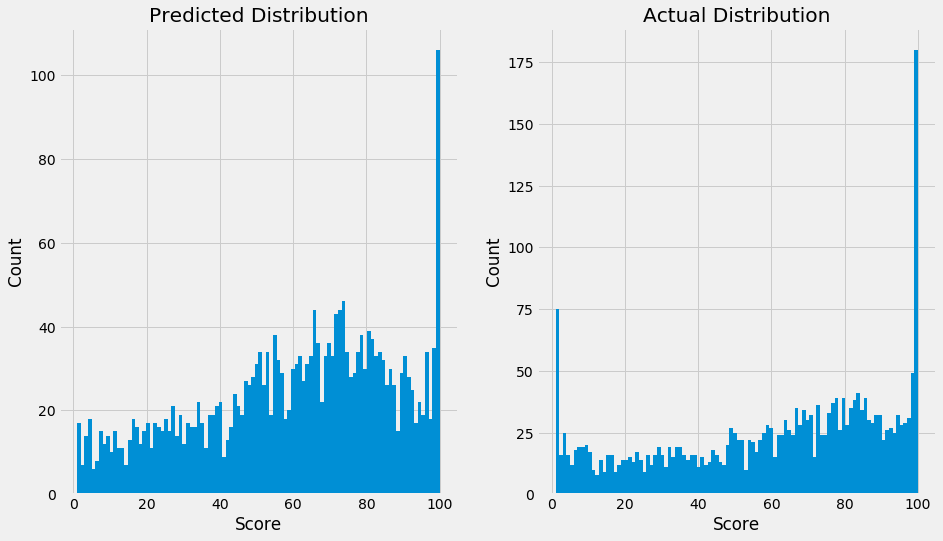

In [19]:
figsize(14, 8)

# Plot predictions
ax = plt.subplot(121)
ax.hist(rf_reg_pred, bins = 100)
ax.set_xlabel('Score'); ax.set_ylabel('Count'); 
ax.set_title('Predicted Distribution')

# Plot true values
ax2 = plt.subplot(122)
ax2.hist(y_test, bins = 100)
ax2.set_xlabel('Score'); ax2.set_ylabel('Count'); 
ax2.set_title('Actual Distribution');

The model can predict the mode of scores at 100, does not seem to be able to predict the low scores very well. Fixing this imbalance could be an area of future work. We could also try different models to optimize the error, but for now we have shown that machine learning is amenable to the problem.

### Predicted Scores of New Buildings

Now we can use the model to generate new predictions for the buildings with missing scores.

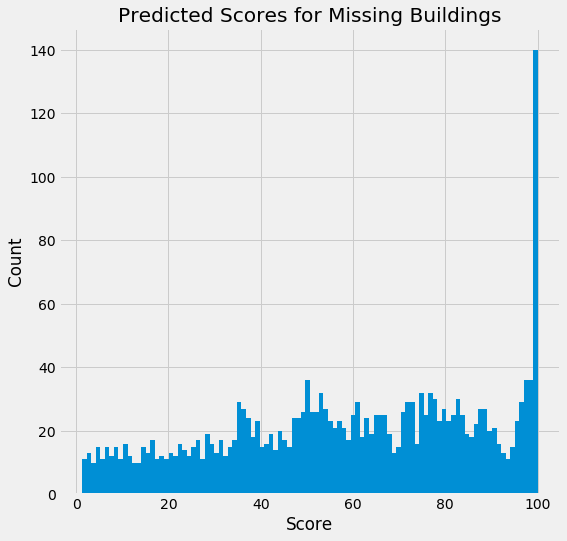

In [20]:
# Predict for the buildings missing energy star scores
missing_preds = rf_reg.predict(missing_scores)

figsize(8, 8)

# Distribution of predicted scores
plt.hist(missing_preds, bins = 100);
plt.xlabel('Score'); plt.ylabel('Count'); 
plt.title('Predicted Scores for Missing Buildings');

Our model can now make a prediction for any new building as long as it has the measurements recorded in the original data. We can use this trained model to infer the score and we know that our estimate should be within 10 points of the true value.

### Interpret Feature Importances

The main way we can get an understanding of the random forest model is to look at which features it considers most important. The absolute values of the feature importances are not as crucial as the relative ranking of variables. These tell us which varibles are most useful for predicting the Energy Star Score.

In [0]:
def interpret_features(feature_list, importances):
    # Make a dataframe of features and importances
    feature_df = pd.DataFrame({'feature': feature_list, 
                               'importance': importances})
    
    # Sort the features from most to least important
    feature_df = feature_df.sort_values('importance', ascending = False)
    figsize(8, 8)
    
    # Plot the most important features
    plt.bar(feature_df[feature_df['importance'] > 0.01]['feature'], 
            feature_df[feature_df['importance'] > 0.01]['importance'])
    
    # Plot formatting
    plt.xticks(rotation = 90)
    plt.xlabel('feature'); plt.ylabel('importance'); 
    plt.title('Top Feature Importances')
    plt.show();
    
    return feature_df

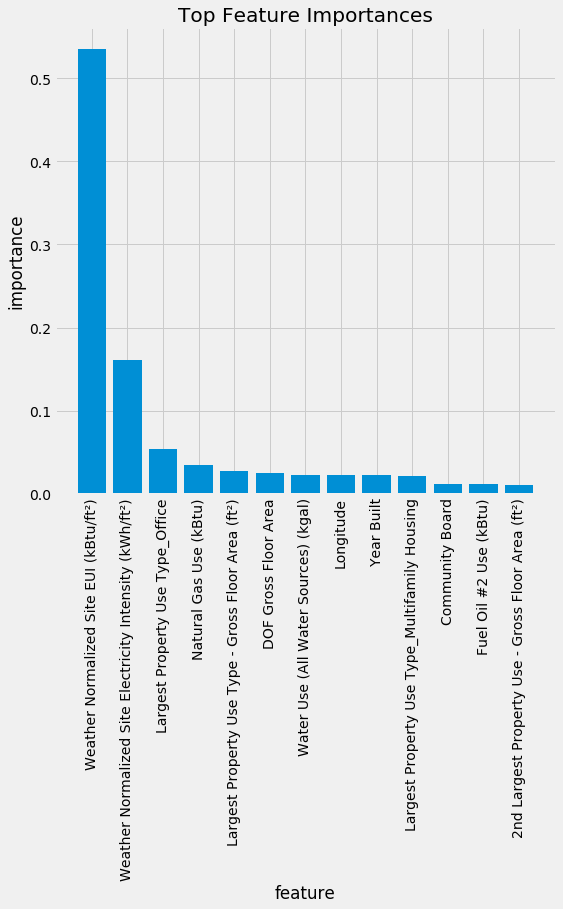

In [22]:
reg_features = interpret_features(feature_names, rf_reg.feature_importances_)

In [23]:
reg_features.head(10)

,feature,importance
7,Weather Normalized Site EUI (kBtu/ft²),0.534495
8,Weather Normalized Site Electricity Intensity ...,0.160984
40,Largest Property Use Type_Office,0.054123
12,Natural Gas Use (kBtu),0.034690
1,Largest Property Use Type - Gross Floor Area (...,0.027429
0,DOF Gross Floor Area,0.025392
13,Water Use (All Water Sources) (kgal),0.023117
14,Longitude,0.022774
4,Year Built,0.022273
37,Largest Property Use Type_Multifamily Housing,0.021832


According to the random forest model, the most importance features for predicting the Energy Star Score of a building are the (1)Site EUI, the (2)Electricity Intensity, the (3)Property Use Type, the (4)Natural Gas Use, and the (5)Area. These are in line with the variables that we saw are the most correlated with the Energy Star Score. 

Let's take a look at the relationship between the Energy Star Score, the Site EUI, the electricity intensity, the Natural Gas Use, and the area of the building. In the exploration, we noticed that these relationships are closer to linear when the log transform of the variable is taken. We will apply that transformation and look at the resulting relationships.

In [24]:
# List of Features to Plot
features = ['Weather Normalized Site EUI (kBtu/ft²)',
            'Weather Normalized Site Electricity Intensity (kWh/ft²)',
             'Largest Property Use Type - Gross Floor Area (ft²)',
             'Natural Gas Use (kBtu)',
             'ENERGY STAR Score']

subset = new_data[features].dropna()

# Rename the columns
subset.columns = ['Site EUI', 'Electricity Intensity', 
                  'Floor Area', 'Natural Gas', 'Score']

# Remove outliers and problem values
subset = subset[subset['Site EUI'] < 300]

# Log Transforms
subset['log Site EUI'] = np.log(subset['Site EUI'])
subset['log Electricity Intensity'] = np.log(subset['Electricity Intensity'])
subset['log Floor Area'] = np.log(subset['Floor Area'])
subset['log Natural Gas'] = np.log(subset['Natural Gas'])

subset = subset.replace({-np.inf: np.nan})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


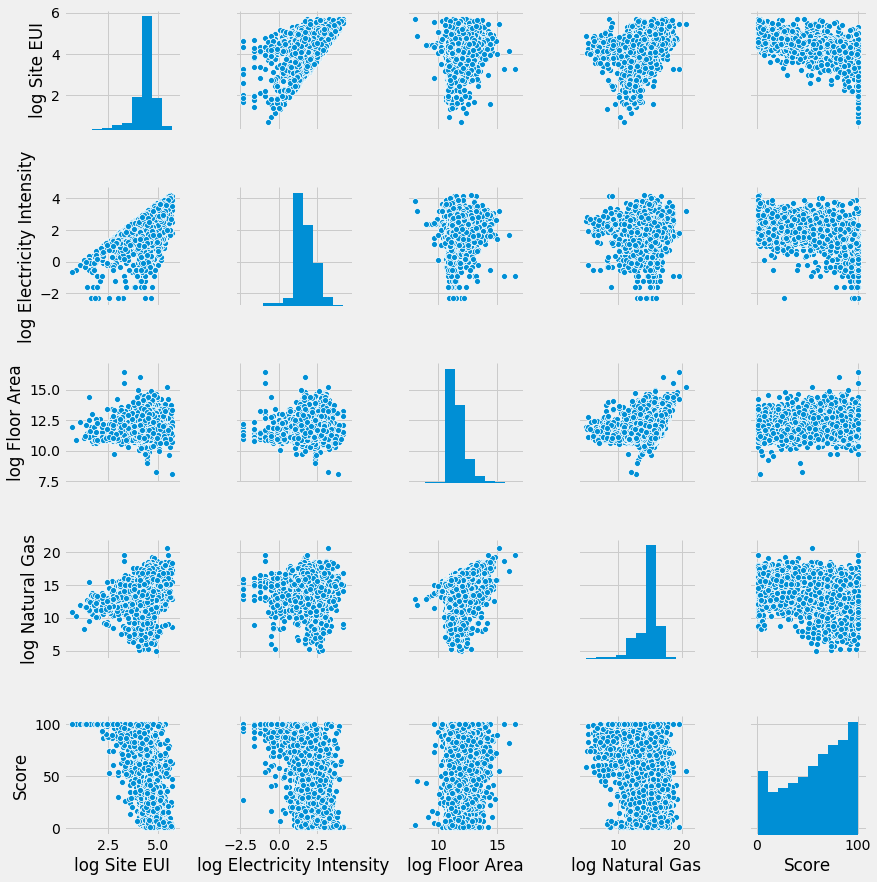

In [25]:
sns.pairplot(subset.dropna()[['log Site EUI', 'log Electricity Intensity', 
                              'log Floor Area', 'log Natural Gas', 'Score']]);

This graph is not that informative. We can see that the Energy Star Score is negatively correlated with the Site EUI, the Electricity Intensity, and the natural gas usage. There is no significant relationship between the floor area and the Energy Star Score. 

The overall results of regression show us that it is possible to accurately infer the Energy Star Score of a building given the data available. The model results are not easily explained, but the most important features are in line with those found to be correlated with the Energy Star Score.

## Classification of Energy Star Scores

As an additional exercise, we can see if it is possible to place buildings into classes based on their energy star scores. We'll use a simple grading scheme where every 20 point interval is a grade giving us 5 total.

#### Classification Preprocessing

In [0]:
# Function to generate a training and testing dataset for classification
# Codes the energy star score in 5 unique classes
def train_test_clf(df):

    # Select numeric columns
    X = df.select_dtypes('number')
    
    # Add in specific categorical columns
    X['Largest Property Use Type'] = df['Largest Property Use Type']
    X['Metered Areas (Energy)'] = df['Metered Areas (Energy)']
    X['DOF Benchmarking Submission Status'] = df['DOF Benchmarking Submission Status']
    
    # One Hot Encoding of Categorical Variables
    X = pd.get_dummies(X)
    
    # Save the buildings with missing scores
    missing_scores = X[X['ENERGY STAR Score'].isnull()]
    X = X.dropna(subset = ['ENERGY STAR Score'])
    
    # Assign a grade based on energy star score
    X['grade'] = pd.cut(X['ENERGY STAR Score'], bins = range(0, 101, 20), labels = ['F', 'D', 'C', 'B', 'A'])
    
    y = X['grade']
    
    # Drop labels from training data
    X = X.drop(columns = ['Order', 'Property Id', 'ENERGY STAR Score', 'grade'])
    missing_scores = missing_scores.drop(columns = ['Order', 'Property Id', 'ENERGY STAR Score'])
    feature_names = list(X.columns)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
    
    # Impute the missing values using a median strategy
    imputer = Imputer(strategy = 'median')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    missing_scores = imputer.transform(missing_scores)
    
    return X_train, X_test, y_train, y_test, missing_scores, feature_names

In [27]:
X_train, X_test, y_train, y_test, missing_scores, feature_names = train_test_clf(new_data)

# Look at value counts of grades
pd.Series(y_train).value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

A    2254
B    1690
C    1280
F    1057
D     950
Name: grade, dtype: int64

The most common 'grade' for a building is an A and the least common is an F. The skew towards higher energy star scores is visible once again (self-reporting does not seem to be an objective strategy).

### Random Forest Classifier

In [0]:
# Create and train the classifier
rf_clf = RandomForestClassifier(n_estimators=200)
rf_clf.fit(X_train, y_train)

# Make predictions
rf_clf_pred = rf_clf.predict(X_test)

### Interpret Classification Results

There are many metrics to use for classification. Here we will use accuracy, the [f1 score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), and the confusion matrix. We will use the `weighted` average parameter for the f1 score to account for the class imbalances. The confusion matrix allows us to see what errors our classifier makes.

In [0]:
# Function to plot a confusion matrix
# Includes the numbers of each classification on the plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    
    # Normalize the counts
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the confusion matrix as an image
    plt.figure(figsize(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 22)
    
    # Tick marks show the labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Add the numbers to the plot
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")

    # Formatting
    plt.tight_layout()
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    
# Function the evalute classifications from a model
def evaluate_classifications(true, predictions):
    # Metrics for classifications
    accuracy = np.mean(true == predictions)
    f1_value = f1_score(true, predictions, average='weighted')
    cm = confusion_matrix(true, predictions)
    
    print('Accuracy: {:0.2f}.'.format(accuracy))
    print('F1 score: {:0.2f}.'.format(f1_value))
    
    plot_confusion_matrix(cm, classes = sorted(set(true)))

Accuracy: 0.59.
F1 score: 0.57.


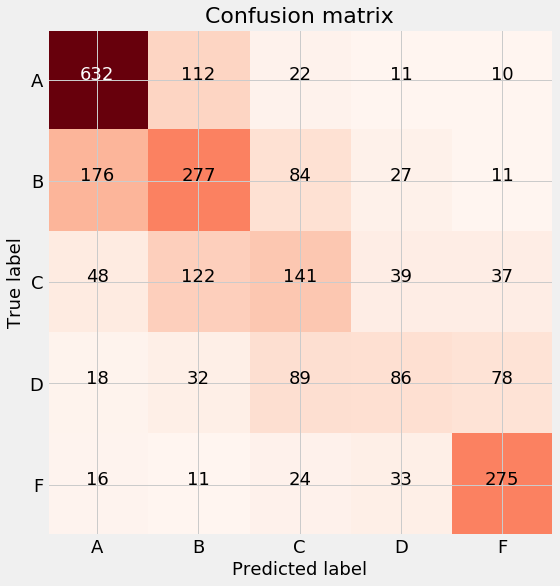

In [30]:
evaluate_classifications(y_test, rf_clf_pred)

Accuracy is a straightforward metric and it shows that our model can correctly choose among the five classes 60% of the time. The confusion matrix is useful because it shows the model mistakes. The most common mistakes are predicting an 'A' when the true label was a 'B', and predicting a 'B' when the true label was a 'C'. The random forest classifier appears to do very well and can accurately infer the Energy Star Score of a building if provided with the building data.

### Predicted Classifications of New Data

The classifier can also be used to assign grades to the buildings which were missing a score. We do not have the true values for these buildings, but we can at least look at the distribution of predictions.

In [31]:
missing_classes = rf_clf.predict(missing_scores)

pd.Series(missing_classes).value_counts()

A    905
F    466
B    341
C    233
D    159
dtype: int64

Any new building can now be classified by the model as long as it is provided with the appropriate data. We can be confident in the predictions of the model as shown by the high performance on the testing data.

## Conclusion

We set out to answer the question: Can we build a model to predict the Energy Star Score of a building and what variables provide us the most information about the score? 

Given the exploration in this notebook, I conclude that __yes__, we can create a model to accurately infer the Energy Star Score of a building and we have determined that the __Site Energy Use Intensity, the Electricity Intensity, the floor area, the natural gas use, and the Building Type__ are the most useful measures for determining the energy star score. 

The highlights from the report are:

1. Energy Star Scores are skewed high with a disproportionate global maximum at 100 and a secondary maximum at 1.
2. Offices, residence halls, and non-refrigerated warehouses have higher energy star scores than senior care communities and hotels with scores of multi-family housing falling in between.
3. The Site Energy Use Intensity, the Electricity Intensity, and the natural gas usage are all negatively correlated with the Energy Star Score.
4. A random forest regressor trained on the training data was able to achieve an average absolute error of 10 points on a hold-out testing set, which was significantly better than the baseline measure.
5. If provided with data for a new building, a trained model can accurately infer the Energy Star Score.

This report also identified areas for follow-up. These include finding an objective measurement of overall building energy performance and determining why the Energy Star Score distributions vary between building types. That's all for now!